<a href="https://colab.research.google.com/github/AsperaDesu/LoL-AI-Draft-Picker/blob/main/code/training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install requests beautifulsoup4 selenium pandas webdriver-manager

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 53.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 499.2/499.2 kB 34.4 MB/s eta 0:00:00


In [2]:
!git clone https://github.com/AsperaDesu/LoL-AI-Draft-Picker.git
%cd LoL-AI-Draft-Picker/code

Cloning into 'LoL-AI-Draft-Picker'...
remote: Enumerating objects: 78, done.
remote: Counting objects: 100% (78/78), done.
remote: Compressing objects: 100% (76/76), done.
remote: Total 78 (delta 33), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (78/78), 6.20 MiB | 9.38 MiB/s, done.
Resolving deltas: 100% (33/33), done.
/content/LoL-AI-Draft-Picker/code


In [3]:
# %load utils.py
HEADERS = {"User-Agent": "Mozilla/5.0"}

import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from bs4 import BeautifulSoup
import pandas as pd
import os
import tempfile


def get_champion_classes():
    url = "https://leagueoflegends.fandom.com/wiki/List_of_champions"
    resp = requests.get(url, headers=HEADERS)
    soup = BeautifulSoup(resp.text, "html.parser")
    table = soup.select_one("table.article-table")
    classes = {}
    for row in table.select("tr")[1:]:
        cols = row.find_all("td")
        if len(cols) < 2:
            continue
        name = cols[0].get("data-sort-value")
        raw = cols[1].get("data-sort-value")
        if name and raw:
            classes[name] = [c.strip() for c in raw.split(",")]
    return classes

def get_champion_scores(patch='14.5'):
    url = f'https://www.metasrc.com/lol/{patch}/stats?ranks=grandmaster,challenger'

    temp_profile = tempfile.mkdtemp()
    options = Options()
    options.add_argument("--headless")
    options.add_argument(f"--user-data-dir={temp_profile}")  # Prevent profile collision
    options.add_argument("--disable-gpu")
    options.add_argument("--no-sandbox")
    options.add_argument("--disable-dev-shm-usage")

    driver = webdriver.Chrome(options=options)

    print(f"Opening MetaSRC patch {patch}...")
    driver.get(url)

    soup = BeautifulSoup(driver.page_source, 'html.parser')
    driver.quit()

    table = soup.find('table')
    if not table:
        raise Exception("Stats table not found.")

    data = []
    rows = table.find_all('tr')[1:]  # Skip header

    for row in rows:
        cols = row.find_all('td')
        if len(cols) < 3:
            continue

        champ = cols[0].find("span").text.strip()
        role = cols[1].get_text(strip=True).lower()
        score = cols[3].get_text(strip=True)
        role = role if role != 'adc' else 'bot'
        data.append({
            "champion": champ,
            "role": role,
            "score": score
        })

    return pd.DataFrame(data)

def load_or_fetch_scores(patch='14.5'):
    file_path = f"champion_scores_{patch}.csv"
    if os.path.exists(file_path):
        print(f"Loading cached scores for patch {patch}")
        df = pd.read_csv(file_path)
        print("-Loading completed")
        return df
    else:
        print(f"Fetching scores for patch {patch} from MetaSRC")
        df = get_champion_scores(patch)
        df.to_csv(file_path, index=False)
        print("-Fetching completed")
        return df

def tokenize_draft(match, tokenizer):
    match["blue_picks"] = tokenizer.encode(match["blue_picks"])
    match["red_picks"] = tokenizer.encode(match["red_picks"])
    match["blue_bans"] = tokenizer.encode(match["blue_bans"])
    match["red_bans"] = tokenizer.encode(match["red_bans"])
    return match

def tokenize_roles(match, tokenizer):
    match["blue_roles"] = tokenizer.encodeRole(match['roles']['blue'])
    match["red_roles"] = tokenizer.encodeRole(match['roles']['red'])
    return match

def drop_raw_picks_bans(match):
    for key in ["match", "blue_team", "red_team", "winner", "roles"]:
        match.pop(key, None)
    return match

In [4]:
from torch.nn import functional as F
import torch.nn as nn
import torch
import os
import json
import math
from pathlib import Path
from utils import *

ROLES = ['Start', 'Banned', 'Jungle', 'Mid', 'Top', 'Bot', 'Support']
START_TOKEN = '<start>'

current_path = Path().resolve()

# Walk up until we find a 'data' folder (as a sibling)
while not (current_path / 'data').exists() and current_path != current_path.parent:
    current_path = current_path.parent

data_dir = current_path / 'data'

if data_dir.exists():
    if Path.cwd() != data_dir:
        os.chdir(data_dir)
        print(f"Changed working directory to: {data_dir}")
    else:
        print(f"Already in data directory: {data_dir}")
else:
    raise FileNotFoundError("Could not find 'data' directory.")

# Getting the draft data
with open('lck_spring_raw.json', 'r') as file:
    data = json.load(file)

for match in data:
  if match['winner'] == match['blue_team']:
      match['winner_token'] = 0
  else:
      match['winner_token'] = 1

Changed working directory to: /content/LoL-AI-Draft-Picker/data


In [5]:
class ChampionTokenizer:
    def __init__(self, champ_names):
        self.champ_names = sorted(set(champ_names))
        self.token_to_id = {name: idx for idx, name in enumerate(self.champ_names)}
        self.id_to_token = {idx: name for name, idx in self.token_to_id.items()}
        self.role_to_id = {role: ix for ix, role in enumerate(ROLES)}
        self.id_to_role = {ix: role for role, ix in self.role_to_id.items()}

    def encode(self, names):
        """Convert a list of champion names into token IDs."""
        return torch.tensor([self.token_to_id[name] for name in names], dtype=torch.long)

    def decode(self, ids):
        """Convert a list of token IDs into champion names."""
        return [self.id_to_token[id.item()] for id in ids]

    def encodeRole(self, roles):
        return torch.tensor([self.role_to_id[role] for role in roles])

    def decodeRole(self, tokens):
        return [self.id_to_role[token] for token in tokens]

    def __len__(self):
        return len(self.champ_names)


class ClassTokenizer:
    def __init__(self, classes):
        self.encoder = {class_: ix for ix, class_ in enumerate(classes)}
        self.decoder = {ix: class_ for class_, ix in self.encoder.items()}

    def encode(self, classes):
        return torch.tensor([self.encoder[class_] for class_ in classes])

    def decode(self, class_tokens):
        return [self.decoder[token.item()] for token in class_tokens]

In [6]:
# Getting champion scores from MetaSRC across patches
patches = set([match['patch'] for match in data])
champion_scores = {patch : load_or_fetch_scores(patch) for patch in patches}

Fetching scores for patch 14.2 from MetaSRC
Opening MetaSRC patch 14.2...
-Fetching completed
Fetching scores for patch 14.1B from MetaSRC
Opening MetaSRC patch 14.1B...
-Fetching completed
Loading cached scores for patch 14.5
-Loading completed
Fetching scores for patch 14.3 from MetaSRC
Opening MetaSRC patch 14.3...
-Fetching completed
Fetching scores for patch 14.4 from MetaSRC
Opening MetaSRC patch 14.4...
-Fetching completed


In [7]:
winner_vocab_size = 3

# Getting the set of available champion names
latest_patch = max(patches)
champion_names = champion_scores[latest_patch]['champion'].tolist()
champion_names.insert(0, START_TOKEN)
champion_names = set(champion_names)

# Initializing champion tokenizer class
champion_vocab_size = len(champion_names)
champ_tokenizer = ChampionTokenizer(champion_names)

In [8]:
# Getting champs classes
champ_classes = get_champion_classes()
champ_classes[START_TOKEN] = ['START']

# Addressing the different naming of "Nunu & Willump"
champ_classes['Nunu'] = champ_classes.pop('Nunu & Willump')

available_classes = set([class_ for classes in champ_classes.values() for class_ in classes])
class_tokenizer = ClassTokenizer(available_classes)

In [9]:
import copy

# Tokenizing and cleaning matches
matches = [tokenize_roles(tokenize_draft(match, champ_tokenizer), champ_tokenizer) for match in copy.deepcopy(data)]
matches = [drop_raw_picks_bans(match) for match in matches]
matches[:5]

[{'patch': '14.5',
  'blue_bans': tensor([ 69, 109,  94,  65, 106]),
  'red_bans': tensor([113,  56, 142,  74,  27]),
  'blue_picks': tensor([147,   2,   1,  19,  10]),
  'red_picks': tensor([ 73, 130,  85,  54, 102]),
  'winner_token': 1,
  'blue_roles': tensor([2, 3, 4, 5, 6]),
  'red_roles': tensor([5, 3, 6, 4, 2])},
 {'patch': '14.5',
  'blue_bans': tensor([112, 142, 148,   1, 147]),
  'red_bans': tensor([ 69, 113,  10,   2,  94]),
  'blue_picks': tensor([ 56, 109, 156, 128,  87]),
  'red_picks': tensor([ 88, 130,  27,  50,  54]),
  'winner_token': 1,
  'blue_roles': tensor([5, 4, 2, 3, 6]),
  'red_roles': tensor([6, 3, 5, 2, 4])},
 {'patch': '14.5',
  'blue_bans': tensor([  2,  56, 138,  54, 101]),
  'red_bans': tensor([123, 113, 142,  53,  73]),
  'blue_picks': tensor([ 94, 106,  50,  55, 104]),
  'red_picks': tensor([163, 130, 147, 140,   5]),
  'winner_token': 1,
  'blue_roles': tensor([3, 4, 2, 5, 6]),
  'red_roles': tensor([5, 3, 2, 4, 6])},
 {'patch': '14.5',
  'blue_bans': 

In [10]:
start_sequence = [{
            "champ_name": START_TOKEN,
            "champ_id": champ_tokenizer.encode([START_TOKEN])[0],
            "team": torch.tensor(0),
            "type": torch.tensor(0),
            "position": torch.tensor(0),
            "role": torch.tensor(0),
            "score": torch.tensor(0, dtype=torch.float),
            "class": torch.tensor([0]),
            "class_name": ["START"],
            "winner_emb": torch.tensor(0),
}]

DRAFT_SEQUENCE = [
    {"team": 1, "type": 1, "index": 0},
    {"team": 2, "type": 1, "index": 0},
    {"team": 1, "type": 1, "index": 1},
    {"team": 2, "type": 1, "index": 1},
    {"team": 1, "type": 1, "index": 2},
    {"team": 2, "type": 1, "index": 2},
    {"team": 1, "type": 2, "index": 0},
    {"team": 2, "type": 2, "index": 0},
    {"team": 2, "type": 2, "index": 1},
    {"team": 1, "type": 2, "index": 1},
    {"team": 1, "type": 2, "index": 2},
    {"team": 2, "type": 2, "index": 2},
    {"team": 2, "type": 1, "index": 3},
    {"team": 1, "type": 1, "index": 3},
    {"team": 2, "type": 1, "index": 4},
    {"team": 1, "type": 1, "index": 4},
    {"team": 2, "type": 2, "index": 3},
    {"team": 1, "type": 2, "index": 3},
    {"team": 1, "type": 2, "index": 4},
    {"team": 2, "type": 2, "index": 4},
]

In [11]:
def structured_sequence(match):
    seq = []
    patch = match['patch']
    patch_champion_scores = champion_scores[patch]

    for pos, op in enumerate(DRAFT_SEQUENCE):
        team = "blue" if op["team"] == 1 else "red"
        champ_ids = match[f"{team}_{'picks' if op['type'] == 2 else 'bans'}"]
        roles = match[f"{team}_roles"]

        champ_id = champ_ids[op["index"]]
        champ_name = champ_tokenizer.decode([champ_id])[0]

        if op['type'] == 2:  # pick
            role_id = roles[op["index"]]
            role = champ_tokenizer.id_to_role[role_id.item()]
            score_csv = patch_champion_scores[
                (patch_champion_scores['champion'] == champ_name) &
                (patch_champion_scores['role'] == role.lower())
            ]
        else:
            role = 'Banned'
            role_id = champ_tokenizer.encodeRole([role])[0]
            score_csv = patch_champion_scores[
                (patch_champion_scores['champion'] == champ_name)
            ]

        class_ = class_tokenizer.encode(champ_classes[champ_name])
        score = float(score_csv['score'].values[0]) if not score_csv.empty else 48.0
        winner_emb = 2 if op['team'] == match['winner_token'] else 1
        seq.append({
            "champ_id": champ_id,
            "team": torch.tensor(op["team"]),
            "type": torch.tensor(op["type"]),
            "position": torch.tensor(pos),
            "role": role_id,
            "class": class_,
            "score": torch.tensor(score),
            "winner_emb": torch.tensor(winner_emb),
        })

    seq = start_sequence + seq
    return seq

**MODEL DESIGNING**

In [12]:
# Hyperparameters
batch_size = 16
champion_emb = 384
n_head = 8
dropout = 0.2
n_layer = 6

SPECIAL_ROLE_IDX = 0  # reserved for start
BANNED_ROLE_IDX = champ_tokenizer.encodeRole(['Banned'])[0]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

sequences = [structured_sequence(match) for match in matches]
n = int(len(sequences) * 0.9)
train_data = sequences[:n]
val_data = sequences[n:]

def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data), (batch_size,))
    batch = [data[i.item()] for i in ix]
    x = [item[:-1] for item in batch]
    y = [item[1:] for item in batch]
    return x, y

class Block(nn.Module):
    def __init__(self, emb_dim, n_head):
        super().__init__()
        self.q_proj = nn.Linear(emb_dim, emb_dim, bias=False)
        self.k_proj = nn.Linear(emb_dim, emb_dim, bias=False)
        self.v_proj = nn.Linear(emb_dim, emb_dim, bias=False)
        self.attention = nn.MultiheadAttention(emb_dim, n_head, dropout=dropout, batch_first=True)
        self.norm1 = nn.LayerNorm(emb_dim)
        self.norm2 = nn.LayerNorm(emb_dim)
        self.ff = nn.Sequential(
            nn.Linear(emb_dim, emb_dim * 4),
            nn.ReLU(),
            nn.Linear(emb_dim * 4, emb_dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        x = self.norm1(x)
        q = self.q_proj(x)
        k = self.k_proj(x)
        v = self.v_proj(x)
        T = x.size(1)
        attn_mask = torch.tril(torch.ones(T, T, device=x.device))
        attn_mask = attn_mask.masked_fill(attn_mask == 0, float('-inf')).masked_fill(attn_mask == 1, float(0.0))
        attn_output, _ = self.attention(q, k, v, attn_mask=attn_mask)
        x = x + attn_output
        x = self.norm2(self.ff(self.norm2(x)))
        return x


class MultiTaskLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.log_var_role = torch.nn.Parameter(torch.zeros(1))
        self.log_var_champ = torch.nn.Parameter(torch.zeros(1))
        self.log_var_joint = torch.nn.Parameter(torch.zeros(1))

    def forward(self, role_loss, champ_loss, joint_loss):
        role_weight  = torch.exp(-self.log_var_role)
        champ_weight = torch.exp(-self.log_var_champ)
        joint_weight = torch.exp(-self.log_var_joint)

        total_loss = (
            role_weight * role_loss + self.log_var_role +
            champ_weight * champ_loss + self.log_var_champ +
            joint_weight * joint_loss + self.log_var_joint
        )
        return total_loss


class DraftModel(nn.Module):
    def __init__(self, champion_vocab_size, team_vocab_size, type_vocab_size, class_vocab_size, winner_vocab_size, emb_dim=128):
        super(DraftModel, self).__init__()
        self.champion_embedding = nn.Embedding(champion_vocab_size, emb_dim)
        self.team_embedding = nn.Embedding(team_vocab_size, emb_dim)
        self.type_embedding = nn.Embedding(type_vocab_size, emb_dim)
        self.position_embedding = nn.Embedding(21, emb_dim)
        self.class_embedding = nn.Embedding(class_vocab_size, emb_dim)
        self.role_embedding = nn.Embedding(len(ROLES), emb_dim)
        self.joint_head = nn.Linear(emb_dim, champion_vocab_size * len(ROLES))
        self.score_proj = nn.Linear(1, emb_dim)

        #winner emb manually declared
        self.winner_embedding = nn.Embedding(winner_vocab_size, 1)
        self.winner_embedding.weight.data = torch.tensor([[1.0], [0.85], [1.15]])
        self.winner_embedding.weight.requires_grad = False  # Optional: freeze weights

        self.blocks = nn.Sequential(*[Block(emb_dim, n_head) for _ in range(n_layer)])
        self.lm_head = nn.Linear(emb_dim, champion_vocab_size)
        self.role_head = nn.Linear(emb_dim, len(ROLES))

        self.multi_loss = MultiTaskLoss()

    def forward(self, batch, target=None):
        B,T = len(batch), len(batch[0])
        champion_ids = torch.stack([
            torch.stack([match['champ_id'] for match in b])
            for b in batch
        ])
        type_ids = torch.stack([
            torch.stack([match['type'] for match in b])
            for b in batch
        ])
        team_ids = torch.stack([
            torch.stack([match['team'] for match in b])
            for b in batch
        ])

        class_ids = torch.stack([torch.stack([pick['class'].sum() for pick in b]) for b in batch])
        positions = torch.arange(T, device=device).unsqueeze(0).expand(B, T)
        score_ids = torch.stack([
            torch.stack([match['score'] for match in b])
            for b in batch
        ]).unsqueeze(-1)

        champ_emb = self.champion_embedding(champion_ids)     # (B, T, C)
        team_emb = self.team_embedding(team_ids)           # (B, T, C)
        type_emb = self.type_embedding(type_ids)           # (B, T, C)
        class_emb = self.class_embedding(class_ids)
        pos_emb = self.position_embedding(positions)       # (B, T, C)
        score_proj = self.score_proj(score_ids)

        role_ids = torch.stack([
            torch.stack([match['role'] for match in b])
            for b in batch
        ])
        role_emb = self.role_embedding(role_ids)

        x = champ_emb + team_emb + type_emb + pos_emb + score_proj + role_emb + class_emb # (B, T, C)

        x = self.blocks(x)
        logits = self.lm_head(x)
        role_logits = self.role_head(x)

        joint_logits = self.joint_head(x)  # (B, T, C × R)
        joint_logits = joint_logits.view(B, T, champion_vocab_size, len(ROLES))
        if target is not None:
            winner_ids = torch.stack([torch.stack([pick['winner_emb'] for pick in match]) for match in batch])  # [B, C]
            winner_emb = self.winner_embedding(winner_ids).unsqueeze(-2)
            joint_logits *= winner_emb
            #champion
            target = champion_ids[:, 1:].contiguous().view(-1)
            logits = logits[:, :-1, :].contiguous().view(B * (T - 1), -1)
            champ_loss = F.cross_entropy(logits, target)
            #role
            role_target = role_ids[:, 1:].contiguous().view(-1)
            role_logits = role_logits[:, :-1, :].contiguous().view(B * (T - 1), -1)
            role_loss = F.cross_entropy(role_logits, role_target)

            joint_target = champion_ids[:, 1:] * len(ROLES) + role_ids[:, 1:]
            joint_logits = joint_logits[:, :-1].reshape(B * (T - 1), -1)
            joint_loss = F.cross_entropy(joint_logits, joint_target.view(-1))

            total_loss = self.multi_loss(role_loss, champ_loss, joint_loss)
        else:
            total_loss = None

        return joint_logits, total_loss


team_vocab_size = 3 # START, Blue, Red
type_vocab_size = 3 # START, Ban, Pick
model = DraftModel(champion_vocab_size, 3, 3, champion_emb, winner_vocab_size)

In [13]:
from math import floor

class DraftPickApp:
    def __init__(self, k=20):
      self.k = k

    def run(self, team_blue, team_red, model, patch=latest_patch):
        picked_mask = torch.zeros(champion_vocab_size, dtype=torch.bool, device=device)
        patch_champion_scores = champion_scores[patch]
        # Role masks for each team
        role_mask = torch.zeros(len(ROLES), dtype=torch.bool, device=device)
        role_mask[SPECIAL_ROLE_IDX] = True
        role_mask[BANNED_ROLE_IDX] = True
        role_masks = {
            1: role_mask.detach().clone(),
            2: role_mask.detach().clone()
        }

        picked_mask[champ_tokenizer.encode([START_TOKEN])[0]] = True
        game = [[start_sequence[0].copy()]]
        teams_input_source = {
            1: {
                'isPlayer': team_blue == 'player',
                'name': 'Blue'
            },
            2: {
                'isPlayer': team_red == 'player',
                'name': 'Red'
            }
        }
        for pick in DRAFT_SEQUENCE:
            team_idx = pick['team']
            team_role_mask = role_masks[team_idx]
            team_isPlayer = teams_input_source[team_idx]['isPlayer']
            team_name = teams_input_source[team_idx]['name']
            if not team_isPlayer:
                joint_logits, _ = model(game)
                joint_logits = joint_logits[:, -1, :, :]  # (1, C, R)

                # Mask picked champions
                joint_logits[0, picked_mask, :] = float('-inf')
                if pick['type'] == 2:
                    joint_logits[0, :, team_role_mask] = float('-inf')
                else:
                  temp_mask = torch.zeros_like(joint_logits, dtype=torch.bool)
                  temp_mask[0, :, BANNED_ROLE_IDX] = True

                  joint_logits = joint_logits.masked_fill(~temp_mask, float('-inf'))
                  joint_logits[0, picked_mask, :] = float('-inf')

                joint_probs = F.softmax(joint_logits.view(-1), dim=0)
                topk_probs, topk_indices = torch.topk(joint_probs, self.k)
                topk_probs = joint_probs[topk_indices]
                topk_probs = topk_probs / topk_probs.sum()
                prob_index = torch.multinomial(topk_probs, 1).item()

                pair_ix = topk_indices[prob_index]
                champ_ix = floor(pair_ix / len(ROLES))
                champ_ix = torch.tensor(champ_ix, device=device)

                # 🟢 Print out the AI's decision
                champ_name = champ_tokenizer.decode([champ_ix])[0]
                print(f"AI {team_name} team", end= ' ')
                if pick['type'] == 1:
                    print(f"banned {champ_name}")
                    role_ix = champ_tokenizer.encodeRole(['Banned'])[0]
                    role_str = "Banned"
                elif pick['type'] == 2:
                    role_ix = pair_ix % len(ROLES)
                    role_str = champ_tokenizer.decodeRole([role_ix.item()])[0]
                    print(f"picked {champ_name} as {role_str}")

            else:
                while True:
                    champ_name = input(f'{"BAN" if pick["type"] == 1 else "PICK"} a champ: ').strip()

                    # Check if it's a known champ
                    if champ_name not in champ_tokenizer.token_to_id:
                        print(f"'{champ_name}' is not a valid champion name. Try again.")
                        continue

                    champ_ix = champ_tokenizer.encode([champ_name])[0]

                    # Check if it's already picked or banned
                    if picked_mask[champ_ix]:
                        print(f"{champ_name} has already been picked or banned. Try again.")
                        continue

                    break  # valid input
                # Ask for role input
                if pick["type"] == 2:
                    while True:
                        role_str = input(f"What role will {champ_name} play? ").strip()
                        if role_str in champ_tokenizer.role_to_id:
                            role_ix = torch.tensor(champ_tokenizer.encodeRole([role_str])[0], device=device)
                            break
                        else:
                            print(f"'{role_str}' is not a valid role. Try again.")
                else:
                  role_ix = champ_tokenizer.encodeRole(['Banned'])[0]
                  role_str = "Banned"

            # Update masks
            picked_mask[champ_ix] = True
            if pick['type'] == 2:
                role_masks[team_idx][role_ix] = True

            # Get class (token & str), meta score
            class_name = None
            class_ = None
            score = 0.0

            if pick['type'] != 0:
                class_name = champ_classes[champ_name]
                class_ = class_tokenizer.encode(class_name)
                if pick['type'] == 1:
                  score_csv = patch_champion_scores[
                      (patch_champion_scores['champion'] == champ_name)
                  ]
                else:
                  score_csv = patch_champion_scores[
                      (patch_champion_scores['champion'] == champ_name) &
                      (patch_champion_scores['role'] == role_str)
                  ]
                score = float(score_csv['score'].values[0]) if not score_csv.empty else 48.0

            new_pick = {
                "champ_name": champ_name,
                "champ_id": champ_ix,
                "team": torch.tensor(pick['team']),
                "type": torch.tensor(pick['type']),
                "position": torch.tensor(pick['index']),
                "role": role_ix,
                "score": torch.tensor(score),
                "class_name": class_name,
                "class": class_
            }
            game[0].append(new_pick)
        return game[0]


def print_draft(draft):
    print(f"{'STEP':<4} | {'ACTION':<6} | {'TEAM':<5} | {'CHAMPION':<15} | {'ROLE':<7} | {'CLASS'}")
    print("-" * 60)
    for i, step in enumerate(draft):
        champ = step["champ_name"]
        team = ["start", "blue", "red"][step["team"]]
        action = ["start", "ban", "pick"][step["type"]]
        class_ = step["class_name"]
        role = champ_tokenizer.id_to_role[step["role"].item()]
        print(f"{i:<4} | {action.upper():<6} | {team.upper():<5} | {champ:<15} | {role:<7} | {', '.join(class_)}")

draftapp = DraftPickApp()

In [ ]:
draftapp = DraftPickApp()
draft = draftapp.run('ai', 'ai', model)
print_draft(draft)

AI Blue team banned Maokai
AI Red team banned Corki
AI Blue team banned Kalista
AI Red team banned Lucian
AI Blue team banned Sejuani
AI Red team banned Senna
AI Blue team picked Vi as Jungle
AI Red team picked Udyr as Top
AI Red team picked Rakan as Support
AI Blue team picked Milio as Support
AI Blue team picked Varus as Bot
AI Red team picked Karma as Mid
AI Red team banned Smolder
AI Blue team banned K'Sante
AI Red team banned Orianna
AI Blue team banned Ashe
AI Red team picked Poppy as Jungle
AI Blue team picked Gnar as Top
AI Blue team picked Azir as Mid
AI Red team picked Aphelios as Bot
STEP | ACTION | TEAM  | CHAMPION        | ROLE    | CLASS
------------------------------------------------------------
0    | START  | START | <start>         | Start   | START
1    | BAN    | BLUE  | Maokai          | Banned  | Vanguard
2    | BAN    | RED   | Corki           | Banned  | Marksman
3    | BAN    | BLUE  | Kalista         | Banned  | Marksman
4    | BAN    | RED   | Lucian        

**MODEL TRAINING**

In [ ]:
optim = torch.optim.Adam(model.parameters(), lr=1e-3)
max_steps = 5000
lossi = []
for i in range(max_steps):
    model.train()
    x, y = get_batch('train')
    _, loss = model(x, y)

    optim.zero_grad()
    loss.backward()
    optim.step()

    if i % 50 == 0:
        print(f"Step {i}, Loss: {loss.item():.4f}")

    lossi.append(loss.item())

torch.save(model.state_dict(), 'model_weights.pth')

Step 0, Loss: 14.8308
Step 50, Loss: 9.7087
Step 100, Loss: 9.1091
Step 150, Loss: 8.5682
Step 200, Loss: 8.3928
Step 250, Loss: 7.6148
Step 300, Loss: 7.3861
Step 350, Loss: 8.7897
Step 400, Loss: 8.3945
Step 450, Loss: 7.9653
Step 500, Loss: 7.8628
Step 550, Loss: 7.6431
Step 600, Loss: 7.6302
Step 650, Loss: 7.4903
Step 700, Loss: 7.4520
Step 750, Loss: 7.3163
Step 800, Loss: 7.2012
Step 850, Loss: 7.0783
Step 900, Loss: 6.9986
Step 950, Loss: 6.9808
Step 1000, Loss: 6.9161
Step 1050, Loss: 6.8073
Step 1100, Loss: 6.7682
Step 1150, Loss: 6.7444
Step 1200, Loss: 6.7231
Step 1250, Loss: 6.6744
Step 1300, Loss: 6.5920
Step 1350, Loss: 6.5602
Step 1400, Loss: 6.4685
Step 1450, Loss: 6.4553
Step 1500, Loss: 6.4100
Step 1550, Loss: 6.3912
Step 1600, Loss: 6.4182
Step 1650, Loss: 6.3700
Step 1700, Loss: 6.3361
Step 1750, Loss: 6.2789
Step 1800, Loss: 6.2414
Step 1850, Loss: 6.3663
Step 1900, Loss: 6.2136
Step 1950, Loss: 6.2084
Step 2000, Loss: 6.1665
Step 2050, Loss: 6.1790
Step 2100, Los

/tmp/ipython-input-64-3327611419.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lossi = torch.tensor(lossi)


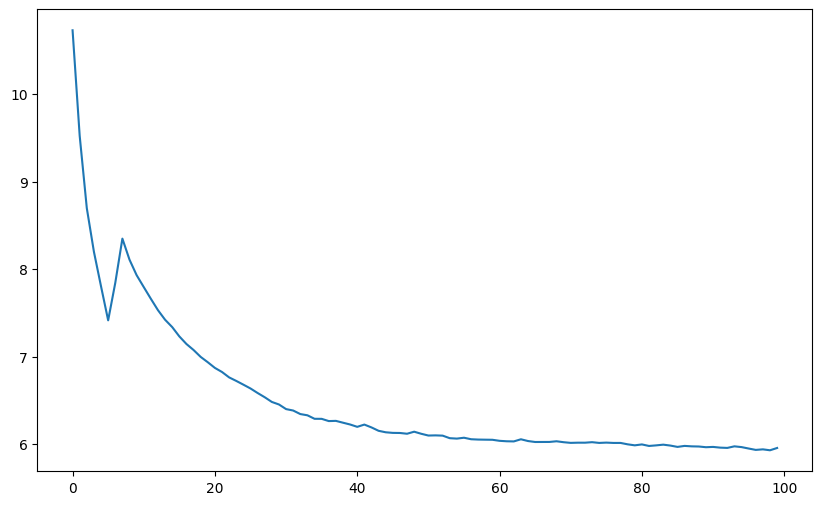

In [ ]:
import matplotlib.pyplot as plt

lossi = torch.tensor(lossi)
loss_50 = lossi.view(-1, 50)
loss_50_mean = loss_50.mean(dim=1)

plt.figure(figsize=(10, 6))
plt.plot(loss_50_mean)

In [14]:
model.load_state_dict(torch.load('model_weights.pth'))
model.eval()  # switch to evaluation mode if you're not training

DraftModel(
  (champion_embedding): Embedding(168, 128)
  (team_embedding): Embedding(3, 128)
  (type_embedding): Embedding(3, 128)
  (position_embedding): Embedding(21, 128)
  (class_embedding): Embedding(384, 128)
  (role_embedding): Embedding(7, 128)
  (joint_head): Linear(in_features=128, out_features=1176, bias=True)
  (score_proj): Linear(in_features=1, out_features=128, bias=True)
  (winner_embedding): Embedding(3, 1)
  (blocks): Sequential(
    (0): Block(
      (q_proj): Linear(in_features=128, out_features=128, bias=False)
      (k_proj): Linear(in_features=128, out_features=128, bias=False)
      (v_proj): Linear(in_features=128, out_features=128, bias=False)
      (attention): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
      )
      (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (ff): Sequential(
        (0): L

In [15]:
draft = draftapp.run('ai', 'ai', model)
print_draft(draft)

AI Blue team banned Ashe
AI Red team banned Maokai
AI Blue team banned Kalista
AI Red team banned Orianna
AI Blue team banned Lee Sin
AI Red team banned Vi
AI Blue team picked Varus as Bot
AI Red team picked K'Sante as Top
AI Red team picked Corki as Mid
AI Blue team picked Sejuani as Jungle
AI Blue team picked Senna as Support
AI Red team picked Smolder as Bot
AI Red team banned Udyr
AI Blue team banned Poppy
AI Red team banned Rakan
AI Blue team banned Azir
AI Red team picked Milio as Support
AI Blue team picked Rumble as Top
AI Blue team picked Tristana as Mid
AI Red team picked Xin Zhao as Jungle
STEP | ACTION | TEAM  | CHAMPION        | ROLE    | CLASS
------------------------------------------------------------
0    | START  | START | <start>         | Start   | START
1    | BAN    | BLUE  | Ashe            | Banned  | Marksman
2    | BAN    | RED   | Maokai          | Banned  | Vanguard
3    | BAN    | BLUE  | Kalista         | Banned  | Marksman
4    | BAN    | RED   | Orianna 

In [ ]:
draft = draftapp.run('player', 'ai', model)
print_draft(draft)

BAN a champ: Azir
AI Red team banned Corki
BAN a champ: Annie
AI Red team banned Poppy
BAN a champ: Vi
AI Red team banned Senna
PICK a champ: Rumble
What role will Rumble play? Top
AI Red team picked Ashe as Support
AI Red team picked K'Sante as Top
PICK a champ: Vi
Vi has already been picked or banned. Try again.
PICK a champ: Jarvan IV
What role will Jarvan IV play? Jungle
PICK a champ: Kalista
What role will Kalista play? Bot
AI Red team picked Orianna as Mid
AI Red team banned Smolder
BAN a champ: Caitlyn
AI Red team banned Ahri
BAN a champ: Karma
AI Red team picked Varus as Bot
PICK a champ: Renata Glasc
What role will Renata Glasc play? Support
PICK a champ: Taliyah
What role will Taliyah play? Mid
AI Red team picked Lee Sin as Jungle
STEP | ACTION | TEAM  | CHAMPION        | ROLE    | CLASS
------------------------------------------------------------
0    | START  | START | <start>         | Start   | START
1    | BAN    | BLUE  | Azir            | Banned  | Specialist
2    | BA